In [1]:
from math import log
import numpy as np
import matplotlib.pyplot as plt
import random
def f(x):
    return x*(log(x+2))**2

def create_points(a, b, n, d, eps = 1e-3):
    x = np.linspace(a, b, n)
    points = []
    for x_i in x:
        for _ in range(d):
            points.append([x_i, f(x_i)+random.uniform(-eps, eps)])
    return np.array(points)

def gauss(A):
    m = len(A)
    n = m + 1
    for k in range(m):
        pivots = [abs(A[i][k]) for i in range(k, m)]
        i_max = pivots.index(max(pivots)) + k
        A[k], A[i_max] = A[i_max], A[k]

        
        for i in range(k + 1, m):
            f = A[i][k] / A[k][k]
            for j in range(k + 1, n):
                A[i][j] -= A[k][j] * f
            A[i][k] = 0    
    x = []
    for i in range(m - 1, -1, -1):
        x.insert(0, A[i][m] / A[i][i])
        for k in range(i - 1, -1, -1):
            A[k][m] -= A[k][i] * x[0]
    return x

def memroize_a(f):
    memory = {}
    def inner(j, points):
        if j not in memory:         
            memory[j] = f(j, points)
        return memory[j]
    return inner

def memroize_b(f):
    memory = {}
    def inner(j, points):
        if j not in memory:         
            memory[j] = f(j, points)
        return memory[j]
    return inner

def memorize_q(f):
    memory = {}
    def inner(j, x, points):
        if (j, x) not in memory:
            memory[(j, x)] = f(j, x, points)
        return memory[(j, x)]
    return inner

def least_squares(a, b, n, d, deg, eps = 1e-3):
    deg+=1
    points = np.array(create_points(a, b, n, d, eps))
    E = np.ndarray([points.shape[0], deg])
    for power in range(deg):
        E[:, power] = (points[:, 0]**power).T
    f = points[:, 1]
    coefs = gauss(list(np.c_[np.dot(E.T, E), np.dot(E.T, f).T]))
    return coefs

@memroize_a
def get_alpha(j, points):
    numer = 0
    denumer = 0
    for point in points[:, 0]:
        numer+=point*get_q(j-1, point, points)**2
        denumer+=get_q(j-1, point, points)**2
    return numer/denumer

@memroize_b
def get_beta(j, points):
    numer = 0
    denumer = 0
    for point in points[:, 0]:
        numer+=point*get_q(j, point, points)*get_q(j-1, point, points)
        denumer+=get_q(j-1, point, points)**2
    return numer/denumer
    
@memorize_q
def get_q(j, x, points):
    if j == 0:
        return 1
    elif j == 1:
        return x-1/(points.shape[0])*points[:, 0].sum()
    else:
        return x*get_q(j-1, x, points) - get_alpha(j, points)*get_q(j-1, x, points)- \
                get_beta(j-1, points)*get_q(j-2, x, points)
        

def orthogonal_least_squares(a, b, n, d, deg, eps = 1e-3):
    points = np.array(create_points(a, b, n, d, eps))
    coefs = []
    for k in range(deg):
        numer = 0
        denumer = 0
        for point in points:
            numer+=get_q(k, point[0], points)*point[1]
            denumer+=get_q(k, point[0], points)**2
        coefs.append(numer/denumer)
    return coefs
    

def polynom(coef, x):
    answ = 0
    for i, a in enumerate(coef):
        answ+=x**i*a
    return answ

def orth_polynom(coef, x, points):
    answ = 0
    for i, a in enumerate(coef):
        answ+=get_q(i, x, points)*a
    return answ

def get_error(a, b, n, coef):
    x = np.linspace(a, b, n)
    answ = sum([(polynom(coef, x_i) - f(x_i))**2 for x_i in x])
    return answ

def get_orth_error(a, b, n, coef):
    x = np.linspace(a, b, n)
    points = create_points(a, b, n, d, eps)
    answ = sum([(orth_polynom(coef, x_i, points) - f(x_i))**2 for x_i in x])
    return answ

def error_list(a, b, n, d):
    print('Таблица ошибок для Метода Наименьших квадратов')
    print(f'Количество точек - {n}, количество значений функции в каждой точке - {d}')
    x = np.linspace(a, b, n)
    for i in range(1, 6):
        coef = least_squares(a, b, n, d, i)
        err = get_error(a, b, n, coef)
        print(f'Степень полинома: {i}, сумма кваратов ошибок: {err}')
        
def orth_error_list(a, b, n, d):
    print('Таблица ошибок для Метода Наименьших квадратов')
    print(f'Количество точек - {n}, количество значений функции в каждой точке - {d}')
    x = np.linspace(a, b, n)
    for i in range(1, 6):
        coef = orthogonal_least_squares(a, b, n, d, i)
        err = get_orth_error(a, b, n, coef)
        print(f'Степень полинома: {i}, сумма кваратов ошибок: {err}')
        
def print_function(a, b, n, d, degree, eps):
    x = np.linspace(a, b, n)
    coefs = least_squares(a, b, n, d, degree, eps)
    y = [polynom(coefs, x_i) for x_i in x]
    points = create_points(a, b, n, d, eps)
    fig, ax = plt.subplots()
    ax.set_title(f'MSE with polynom of {degree} degree', fontsize=20)
    fig.set_size_inches(18.5, 10.5)
    scatter = ax.scatter(points[:, 0], points[:, 1], s=10, c='red', label='Generated points')
    plot = ax.plot(x, y, c='blue', label='MSE approximation')
    ax.legend(loc=2, prop={'size': 20})
    plt.show()
    
def print_orthogonal_function(a, b, n, d, degree, eps):
    x = np.linspace(a, b, n)
    coefs = orthogonal_least_squares(a, b, n, d, degree, eps)
    points = create_points(a, b, n, d, eps)
    y = [orth_polynom(coefs, x_i, points) for x_i in x]
    points = create_points(a, b, n, d, eps)
    fig, ax = plt.subplots()
    ax.set_title(f'Orth MSE with polynom of {degree} degree', fontsize=20)
    fig.set_size_inches(18.5, 10.5)
    scatter = ax.scatter(points[:, 0], points[:, 1], s=10, c='red', label='Generated points')
    plot = ax.plot(x, y, c='blue', label='MSE approximation')
    ax.legend(loc=2, prop={'size': 20})
    plt.show()
    

In [2]:
a = -1.5
b = 3
n = 5000
d = 10
degree = 20
eps = 1e-3

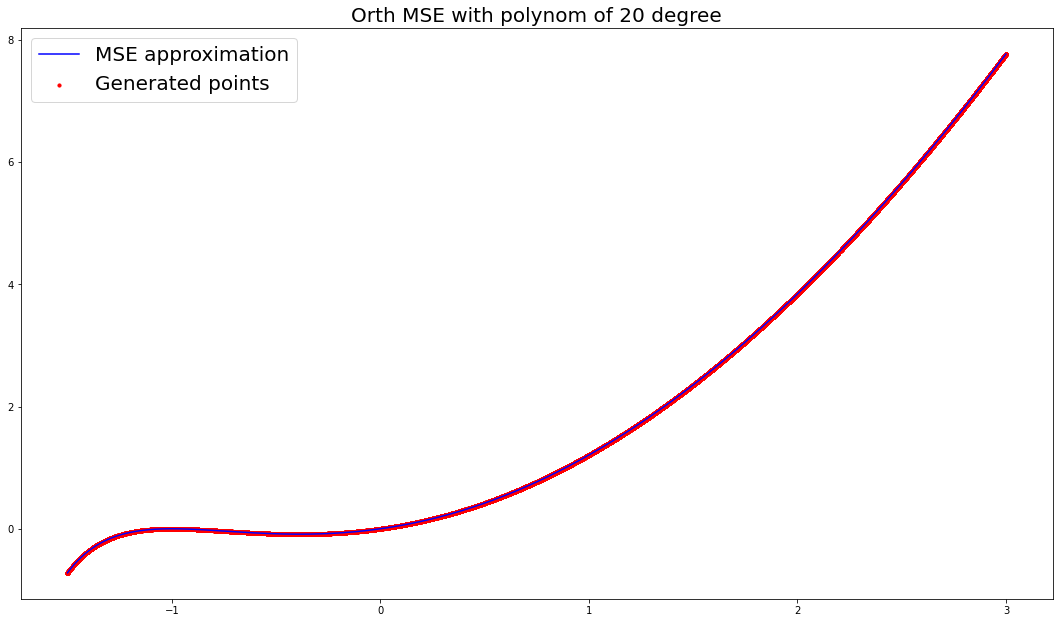

In [ ]:
print_orthogonal_function(a, b, n, d, degree, eps)

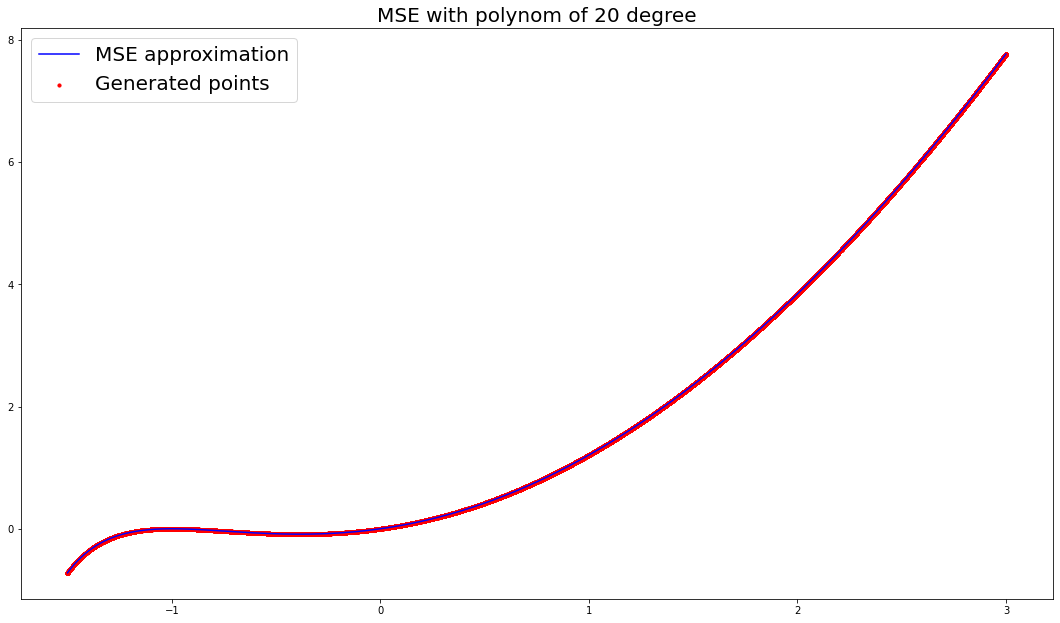

In [4]:
print_function(a, b, n, d, degree, eps)

In [ ]:
error_list(a, b, n, d)

Таблица ошибок для Метода Наименьших квадратов
Количество точек - 5000, количество значений функции в каждой точке - 10
Степень полинома: 1, сумма кваратов ошибок: 4352.447475030839
Степень полинома: 2, сумма кваратов ошибок: 118.49702005910427
Степень полинома: 3, сумма кваратов ошибок: 62.16692877945393
Степень полинома: 4, сумма кваратов ошибок: 17.64375891019708
Степень полинома: 5, сумма кваратов ошибок: 4.4217624260100274


In [3]:
orth_error_list(a, b, n, d)

Таблица ошибок для Метода Наименьших квадратов
Количество точек - 5000, количество значений функции в каждой точке - 10
Степень полинома: 1, сумма кваратов ошибок: 27526.360679548823
Степень полинома: 2, сумма кваратов ошибок: 4352.447475043722
Степень полинома: 3, сумма кваратов ошибок: 118.4970202399974
Степень полинома: 4, сумма кваратов ошибок: 62.166928732507714
Степень полинома: 5, сумма кваратов ошибок: 17.643759029045313
